# Frozen lake with Q-network

Solve the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment using on-policy neural Q-learning with epsilon-greedy action selection.

This approach employs a Q-function which can be updated using bootstrapping:

$$
Q(s,a;\theta) = r + \gamma \max_{a'} Q(s',a';\theta) \ .
$$

Since we use a neural network to represent $Q$, we cannot do this assignment directly, but instead perform a gradient update using squared loss: 

$$
L(\theta) = (r + \gamma \max_{a'} Q(s',a';\theta) - Q(s,a;\theta))^2 \ ,
$$

with transitions $(s,a,r,s')$ sampled from the environment. 

Algorithm:

1. Do a forward pass for current state, $s$, to get predicted Q-values for all actions.
2. Select an action, $a$, with epsilon-greedy strategy and execute it to get next state, $s'$.
3. Do a forward pass for the next state, $s'$.
4. Set Q-target for action $a$ to $r + \gamma \max_{a'} Q(s',a')$ computed in step 2, and to the Q-values from step 1 for all other actions, making the error zero for those outputs.
5. Update network weights with backpropagation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.init_ops import RandomUniform
import gym

In [2]:
env = gym.make('FrozenLake-v0')

[2017-12-20 16:49:10,475] Making new env: FrozenLake-v0


In [3]:
# show init state
s = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [4]:
class QNetwork(object):
    """Q-network"""
    
    def __init__(self, n_inputs, n_outputs, learning_rate):
        self.states = tf.placeholder(tf.float32, [None, n_inputs], name='states')
        self.targets = tf.placeholder(tf.float32, [None, n_outputs], name='targets')
        init = RandomUniform(0, 0.01) # the network is sensitive to weight initialization
        self.out = tf.layers.dense(inputs=self.states, units=n_outputs, activation=None, use_bias=False, kernel_initializer=init, name='out')
        self.loss = tf.reduce_sum(tf.square(self.targets - self.out))
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        self.update = self.optimizer.minimize(self.loss)

In [5]:
def one_hot(i, l):
    """One-hot encoder for the states"""
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a

In [6]:
# train Q-network

num_episodes = 2000
episode_limit = 100
learning_rate = 0.1
gamma = 0.99 # discount rate

print_freq = 100

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

tf.reset_default_graph()
qnet = QNetwork(n_inputs, n_outputs, learning_rate)

try:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        rewards, lengths, losses, epsilons = [], [], [], []
        epsilon = 1.0
        print('start training')
        for i in range(num_episodes):
            s = env.reset()
            reward = 0
            loss = 0
            for j in range(episode_limit):
                # 1. do foward pass of current state to compute Q-values for all actions
                Q = sess.run(qnet.out, feed_dict={qnet.states: one_hot([s], n_inputs)})
                # 2. select action with epsilon-greedy strategy
                a = np.argmax(Q) if np.random.rand() > epsilon else env.action_space.sample()
                s1, r, done, _ = env.step(a)
                # 3. do forward pass for the next state
                Q1 = sess.run(qnet.out, feed_dict={qnet.states: one_hot([s1], n_inputs)})
                # 4. set Q-target
                target = Q
                target[0, a] = r + gamma * np.max(Q1) * (not done)
                # 5. update network weights
                l, _ = sess.run([qnet.loss, qnet.update], feed_dict={qnet.states: one_hot([s], n_inputs), qnet.targets: target})
                # bookkeeping
                s = s1
                reward += r
                loss += l
                if done: break
            epsilon *= num_episodes/(i/(num_episodes/20)+num_episodes) # decrease epsilon
            epsilons.append(epsilon)
            rewards.append(reward)
            lengths.append(j+1)
            losses.append(loss)
            if (i+1) % print_freq == 0: print('%5d avg. reward: %5.2f' % (i+1, np.mean(rewards[-print_freq:])))
        print('done')
except KeyboardInterrupt:
    pass 

start training
  100 avg. reward:  0.00
  200 avg. reward:  0.02
  300 avg. reward:  0.02
  400 avg. reward:  0.01
  500 avg. reward:  0.01
  600 avg. reward:  0.05
  700 avg. reward:  0.16
  800 avg. reward:  0.16
  900 avg. reward:  0.26
 1000 avg. reward:  0.42
 1100 avg. reward:  0.41
 1200 avg. reward:  0.58
 1300 avg. reward:  0.35
 1400 avg. reward:  0.50
 1500 avg. reward:  0.66
 1600 avg. reward:  0.69
 1700 avg. reward:  0.58
 1800 avg. reward:  0.49
 1900 avg. reward:  0.72
 2000 avg. reward:  0.68
done


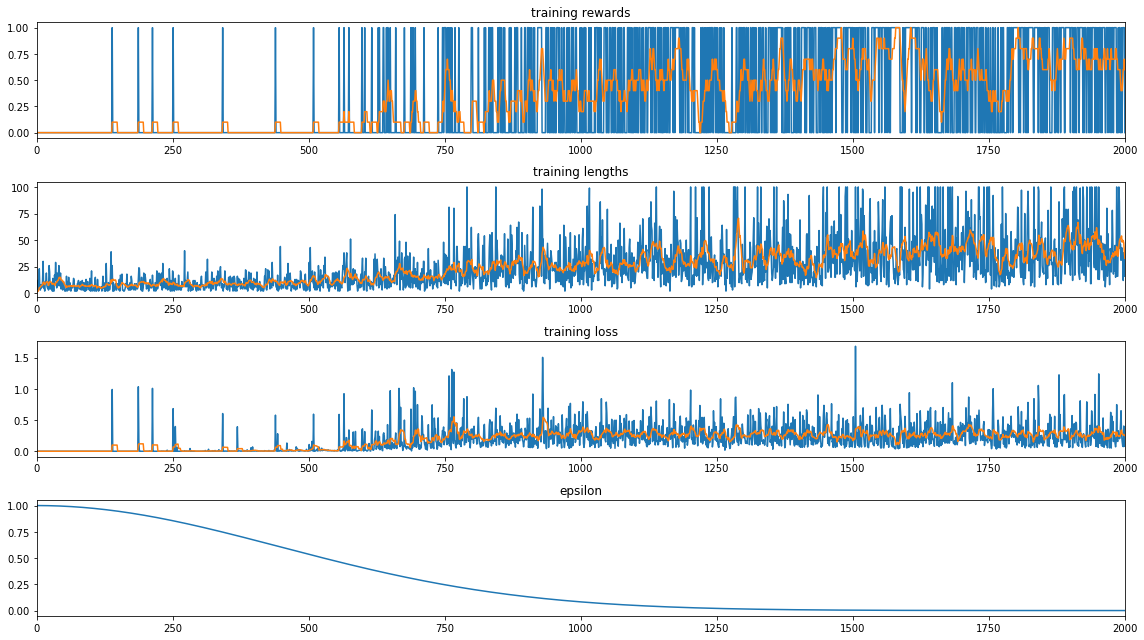

In [7]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(range(1, num_episodes+1), moving_average(rewards))
plt.xlim([0, num_episodes])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])
plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])
plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])
plt.tight_layout(); plt.show()